In [108]:
import os, os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import tensorflow
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
# from scipy import ndimage, misc
import shutil

In [2]:
directory = os.path.join('', 'Images/')
imageid = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(directory, '*', '*.jpg'))}
print(imageid['ISIC_0034133'])

Images/HAM10000_images_part_2/ISIC_0034133.jpg


In [3]:
lesion_type = {
    'akiec': 'Actinic keratoses',
    'bcc': 'basal cell carcinoma',
    'bkl': 'benign keratosis',
    'df': 'dermatofibroima',
    'mel': 'melanoma',
    'nv': 'melanocytic nevi',
    'vasc': 'vascular lesions'
}

In [4]:
data = pd.read_csv('HAM10000_metadata.csv')
data['path'] = data['image_id'].map(imageid.get)
data['cell_type'] = data['dx'].map(lesion_type.get)
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0027419.jpg,benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0025030.jpg,benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0026769.jpg,benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0025661.jpg,benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Images/HAM10000_images_part_2/ISIC_0031633.jpg,benign keratosis,2


In [5]:
# Cleaning data

In [6]:
data.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
data['age'].fillna((data['age'].mean()), inplace=True)

In [8]:
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
# make image column

In [10]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [11]:
data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0027419.jpg,benign keratosis,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0025030.jpg,benign keratosis,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0026769.jpg,benign keratosis,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Images/HAM10000_images_part_1/ISIC_0025661.jpg,benign keratosis,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Images/HAM10000_images_part_2/ISIC_0031633.jpg,benign keratosis,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


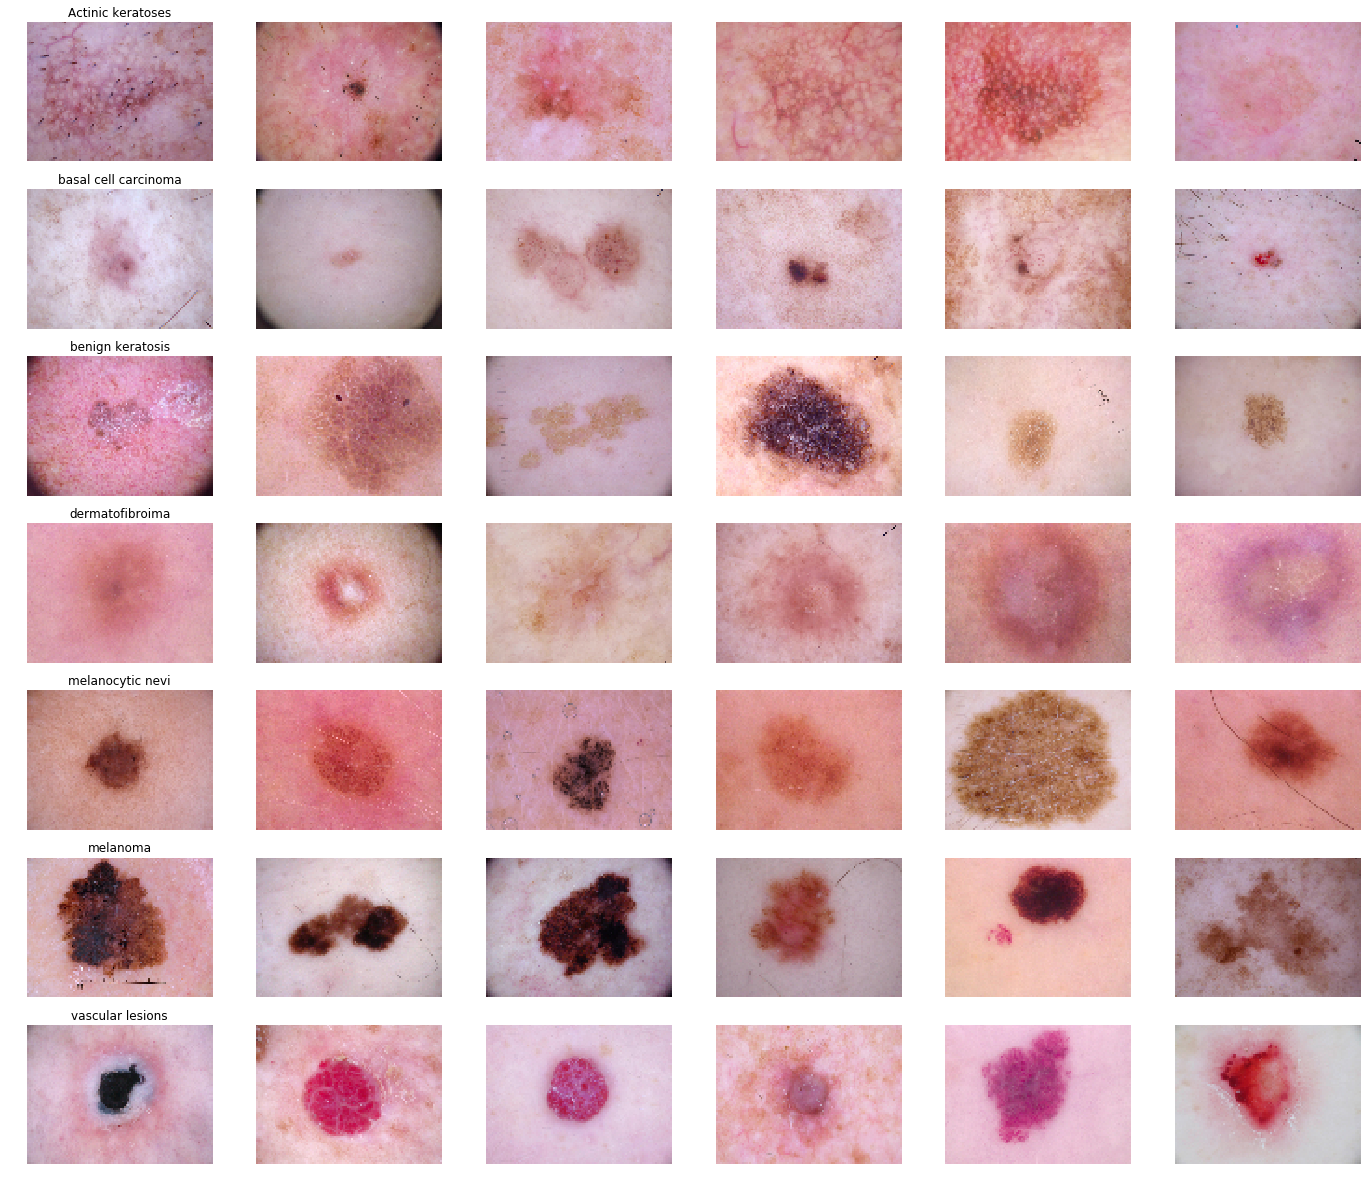

In [12]:
n_samples = 6
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1235).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('Results/category_samples.png', dpi=300)

In [13]:
# check image size distribution
data['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [62]:
data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [91]:
# Split train and test data
X = data.drop('cell_type_idx', 1)
y = data['cell_type_idx']
    
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=1235, stratify=X['cell_type'])
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X_train_all, y_train_all, test_size=0.1, random_state=1235, stratify=X_train_all['cell_type'])
print(X_train_all.shape)
print(X_val_all.shape)

(7210, 10)
(802, 10)


In [86]:
# Normalizing the data

def normalize_data(data):
    data_np = np.asarray(data['image'].tolist())
    mean = np.mean(data_np)
    std = np.std(data_np)
    return (data_np - mean) / std

X_train = normalize_data(X_train_all)
X_test = normalize_data(X_test_all)
X_val = normalize_data(X_val_all)

In [87]:
# Label encoding
def label_encoding(data):
    return to_categorical(data, num_classes=7)


y_train = label_encoding(y_train_all)
y_test = label_encoding(y_test_all)
y_val = label_encoding(y_val_all)

In [166]:
# Model
def build_model(optimizer, loss):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(75, 100, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model
model = build_model('rmsprop', 'categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 73, 98, 32)        896       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 36, 49, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 34, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 17, 23, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 15, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 7, 10, 128)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 8960)              0         
__________

In [89]:
# K-fold cross validation
epochs = 50
batch_size = 10
kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=1235)
cvsores = []
'''
for train, val in kfold.split(X_train, y_train_all):
    # create model
    model = build_model('rmsprop', 'categorical_crossentropy')
    datagen = ImageDataGenerator()
    history = model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=X_train.shape[0] // batch_size, 
        epochs = epochs,
        validation_data = (train, val),
        validation
    )
    loss_train, accuracy_train = model.evaluate(train, val, verbose=1)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_train, loss_train))
    cvscores.append(accuracy_train)
print('Mean accuracy: %f' % np.mean(cvscores))
'''





SyntaxError: positional argument follows keyword argument (<ipython-input-89-81512ddc1bba>, line 16)

In [63]:
# data preparation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [117]:
def get_history(model, Xtrain=X_train, ytrain=y_train, Xval = X_val, yval = y_val):
    return model.fit_generator(
        datagen.flow(Xtrain, ytrain, batch_size=batch_size),
        steps_per_epoch=Xtrain.shape[0] // batch_size,
        epochs=epochs,
        validation_data=(Xval, yval),
        validation_steps=Xval.shape[0] // batch_size
    )

In [92]:
epochs = 50 
batch_size = 10
model_rms_binary_cross = build_model('rmsprop', 'binary_crossentropy')
history_rms_binary = get_history(model_rms_binary_cross)

Epoch 1/50
721/721 [==============================] - 11s 15ms/step - loss: 0.2285 - acc: 0.9122 - val_loss: 0.2195 - val_acc: 0.9124
Epoch 2/50
721/721 [==============================] - 10s 14ms/step - loss: 0.2048 - acc: 0.9202 - val_loss: 0.2015 - val_acc: 0.9138
Epoch 3/50
721/721 [==============================] - 10s 14ms/step - loss: 0.1958 - acc: 0.9237 - val_loss: 0.1697 - val_acc: 0.9291
Epoch 4/50
721/721 [==============================] - 10s 14ms/step - loss: 0.1948 - acc: 0.9255 - val_loss: 0.1750 - val_acc: 0.9332
Epoch 5/50
721/721 [==============================] - 10s 14ms/step - loss: 0.1956 - acc: 0.9254 - val_loss: 0.1773 - val_acc: 0.9263
Epoch 6/50
721/721 [==============================] - 10s 14ms/step - loss: 0.1967 - acc: 0.9261 - val_loss: 0.1993 - val_acc: 0.9127
Epoch 7/50
721/721 [==============================] - 10s 14ms/step - loss: 0.2031 - acc: 0.9235 - val_loss: 0.1926 - val_acc: 0.9298
Epoch 8/50
721/721 [==============================] - 10s 14ms

In [167]:
loss, accuracy= model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

802/802 [==============================] - 0s 127us/step
Validation: accuracy = 0.164589  ;  loss_v = 1.918142
Test: accuracy = 0.192711  ;  loss = 1.901689


In [94]:
# function to plot model's validation loss and validation accuracy

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

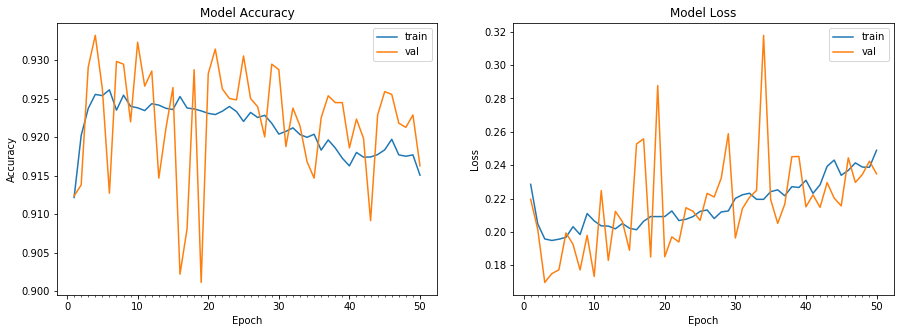

In [95]:
plot_model_history(history)

In [118]:
model_adam_categorical = build_model(optimizers.Adam(0.001), 'categorical_crossentropy')
history_adam_categorical = get_history(model_adam_categorical)

Epoch 1/50
721/721 [==============================] - 12s 16ms/step - loss: 0.9513 - acc: 0.6706 - val_loss: 0.8148 - val_acc: 0.6933
Epoch 2/50
721/721 [==============================] - 10s 14ms/step - loss: 0.8473 - acc: 0.6951 - val_loss: 0.7440 - val_acc: 0.7232
Epoch 3/50
721/721 [==============================] - 11s 15ms/step - loss: 0.7912 - acc: 0.7128 - val_loss: 0.7313 - val_acc: 0.7369
Epoch 4/50
721/721 [==============================] - 11s 15ms/step - loss: 0.7399 - acc: 0.7338 - val_loss: 0.7141 - val_acc: 0.7219
Epoch 5/50
721/721 [==============================] - 10s 15ms/step - loss: 0.7139 - acc: 0.7370 - val_loss: 0.6951 - val_acc: 0.7544
Epoch 6/50
721/721 [==============================] - 10s 14ms/step - loss: 0.6810 - acc: 0.7551 - val_loss: 0.6680 - val_acc: 0.7631
Epoch 7/50
721/721 [==============================] - 10s 14ms/step - loss: 0.6576 - acc: 0.7559 - val_loss: 0.7082 - val_acc: 0.7257
Epoch 8/50
721/721 [==============================] - 10s 14ms

802/802 [==============================] - 0s 149us/step
Validation: accuracy = 0.947631  ;  loss_v = 0.233423
Test: accuracy = 0.753869  ;  loss = 1.199307


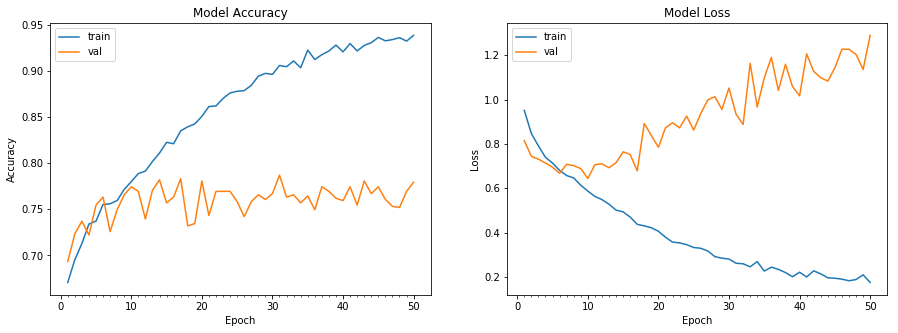

In [124]:
loss, accuracy = model_adam_categorical.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model_adam_categorical.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model_adam_categorical.h5")
plot_model_history(history_adam_categorical)

In [164]:
model_adam_binary = build_model(optimizers.Adam(0.001), loss='binary_crossentropy')
history_adam_binary = get_history(model_adam_binary)

Epoch 1/50
721/721 [==============================] - 12s 16ms/step - loss: 0.2210 - binary_accuracy: 0.9137 - categorical_accuracy: 0.6705 - acc: 0.9137 - val_loss: 0.1944 - val_binary_accuracy: 0.9229 - val_categorical_accuracy: 0.6870 - val_acc: 0.9229
Epoch 2/50
721/721 [==============================] - 11s 15ms/step - loss: 0.1969 - binary_accuracy: 0.9225 - categorical_accuracy: 0.6940 - acc: 0.9225 - val_loss: 0.1936 - val_binary_accuracy: 0.9243 - val_categorical_accuracy: 0.7007 - val_acc: 0.9243
Epoch 3/50
721/721 [==============================] - 11s 15ms/step - loss: 0.1835 - binary_accuracy: 0.9261 - categorical_accuracy: 0.7227 - acc: 0.9261 - val_loss: 0.1660 - val_binary_accuracy: 0.9373 - val_categorical_accuracy: 0.7556 - val_acc: 0.9373
Epoch 4/50
721/721 [==============================] - 11s 15ms/step - loss: 0.1774 - binary_accuracy: 0.9285 - categorical_accuracy: 0.7262 - acc: 0.9285 - val_loss: 0.1930 - val_binary_accuracy: 0.9325 - val_categorical_accuracy: 0

Epoch 33/50
721/721 [==============================] - 10s 14ms/step - loss: 0.0777 - binary_accuracy: 0.9697 - categorical_accuracy: 0.8911 - acc: 0.9697 - val_loss: 0.1912 - val_binary_accuracy: 0.9366 - val_categorical_accuracy: 0.7718 - val_acc: 0.9366
Epoch 34/50
721/721 [==============================] - 10s 14ms/step - loss: 0.0823 - binary_accuracy: 0.9686 - categorical_accuracy: 0.8882 - acc: 0.9686 - val_loss: 0.2167 - val_binary_accuracy: 0.9400 - val_categorical_accuracy: 0.7830 - val_acc: 0.9400
Epoch 35/50
721/721 [==============================] - 11s 15ms/step - loss: 0.0708 - binary_accuracy: 0.9721 - categorical_accuracy: 0.9006 - acc: 0.9721 - val_loss: 0.2113 - val_binary_accuracy: 0.9396 - val_categorical_accuracy: 0.7805 - val_acc: 0.9396
Epoch 36/50
721/721 [==============================] - 11s 15ms/step - loss: 0.0762 - binary_accuracy: 0.9709 - categorical_accuracy: 0.8960 - acc: 0.9709 - val_loss: 0.2006 - val_binary_accuracy: 0.9366 - val_categorical_accurac

802/802 [==============================] - 0s 127us/step
Validation: accuracy = 0.980941  ;  loss_v = 0.067356
Test: accuracy = 0.931103  ;  loss = 0.275553


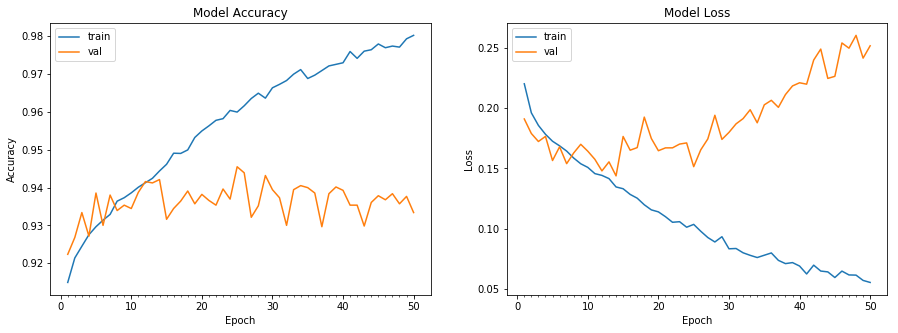

In [125]:
loss, accuracy = model_adam_binary.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model_adam_binary.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model_adam_binary.h5")
plot_model_history(history_adam_binary)

In [188]:
def check(index):
    X_image = np.expand_dims(X_test[index], axis=0)
    y = model_adam_binary.predict(X_image)
    print(y)
    print(np.max(y))
    print(np.where(y == np.max(y)))
    v = np.where(y == np.max(y))[1][0]
    print(bool(y_test[index][v]))
    print(y_test[index])

    
for i in range(0, 20):
    check(i)
    print('----')

[[8.0521802e-22 7.7386516e-23 6.4656115e-07 1.3278275e-22 9.9996316e-01
  3.6221441e-05 2.2869366e-14]]
0.99996316
(array([0]), array([4]))
True
[0. 0. 0. 0. 1. 0. 0.]
----
[[1.4654987e-07 1.4096083e-10 1.3853366e-05 2.5178444e-14 9.3181616e-01
  6.8169862e-02 8.8413579e-09]]
0.93181616
(array([0]), array([4]))
True
[0. 0. 0. 0. 1. 0. 0.]
----
[[9.1767809e-12 1.9795975e-12 6.7360385e-04 5.7945601e-12 9.9931371e-01
  1.2780202e-05 3.2286916e-08]]
0.9993137
(array([0]), array([4]))
True
[0. 0. 0. 0. 1. 0. 0.]
----
[[9.9946374e-01 1.7814823e-07 4.2528618e-04 1.0790171e-05 2.1236991e-05
  7.8877449e-05 2.9918350e-09]]
0.99946374
(array([0]), array([0]))
True
[1. 0. 0. 0. 0. 0. 0.]
----
[[9.0284903e-23 2.7704563e-22 1.6215612e-09 4.1162617e-18 9.9998796e-01
  1.2061792e-05 8.2720225e-17]]
0.99998796
(array([0]), array([4]))
True
[0. 0. 0. 0. 1. 0. 0.]
----
[[8.9435996e-20 1.9328846e-19 8.6176951e-12 1.0665922e-14 9.9999988e-01
  6.0303208e-08 1.0743447e-18]]
0.9999999
(array([0]), array([4]